In [1]:
import os

# get working directory
#os.getcwd()

os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import pathlib

import get_voting_scores as gvs

In [3]:
import pathlib
DATAPATH = pathlib.Path().resolve().parent / "data"

In [4]:
# Get the voting scores
df = gvs.get_voting_scores(DATAPATH / "eurovision_voting_scores_1975_2019.xlsx")

import pickle
country_codes_dict = pickle.load(open(DATAPATH / "country_codes_dict.pickle", "rb"))

In [5]:
df= df.replace({pd.NA: np.nan})

def sum_values(vals):
    # if all nan, then set as nan
    if np.all(np.isnan(vals)):
        return np.nan
    else:
        return vals.sum()

# for each country and year, get the sum values
df_plot = df.groupby(['Year', 'To country'])['Votes'].agg(sum_values).reset_index()

# Add column for the country position for each year - this may differ slightly 
# from official results in later year (due to ties)
df_plot['Position'] = df_plot.groupby('Year')['Votes'].rank(ascending=False)


## Total votes for a country over time

In [6]:
import seaborn as sns
sns.set_theme(style="whitegrid")

my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y) / (26)

def plot_country(country, ax):
    df_temp = df_plot.loc[df_plot['To country'] == country]

    # add dummy data for years not included in the data
    missing_years = list(set(range(1997, 2023)) - set(df_temp['Year']))

    # sort by year
    df_temp = df_temp.sort_values('Year', ascending=False)    
    df_temp['Position'] = df_temp['Position'].astype(float)

    # matplotlib bar chart
    ax.bar(df_temp['Year'], df_temp['Votes'], 
            color=my_cmap(rescale(df_temp['Position'])))

    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp['Votes']):
        if np.isnan(v):
            ax.scatter(df_temp['Year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['Position'] == 1]
    if winner.shape[0] > 0:
        ax.scatter(winner['Year'].iloc[0], winner['Votes'].iloc[0], s=50, 
                   color='gold', marker="*", edgecolor='black', zorder=5)
    
    country_name = pycountry.countries.get(alpha_2=country).name
    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


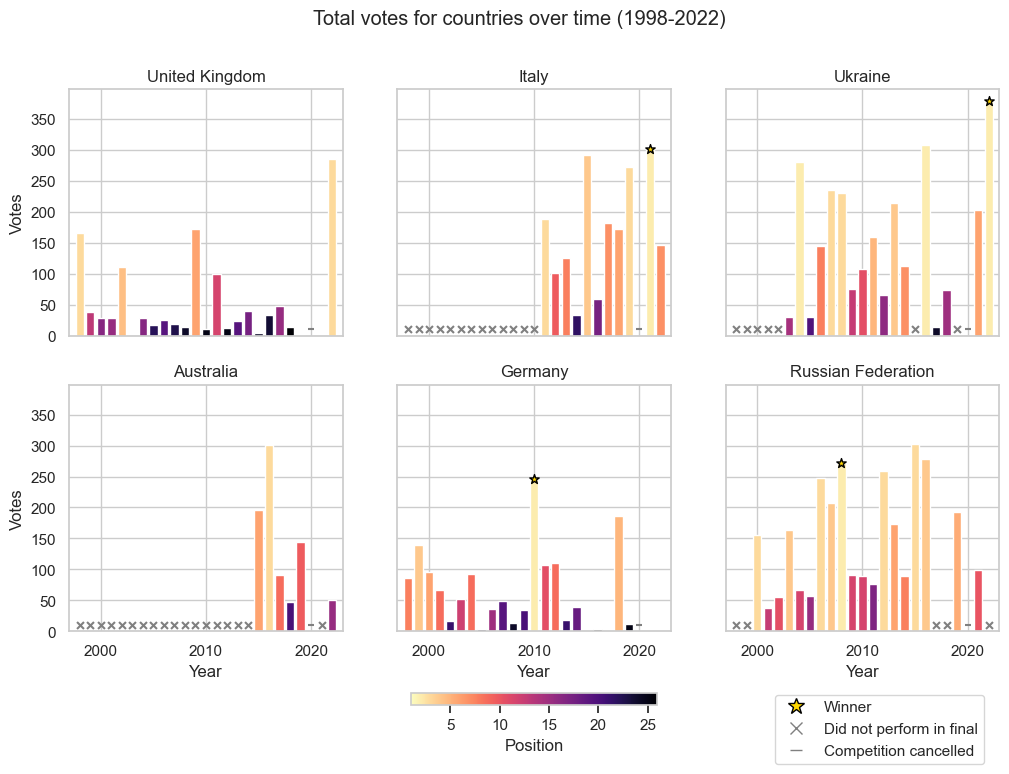

In [7]:
# create a bar chart for GB coloured by winner
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax[0, 0])
plot_country('IT', ax[0, 1])
plot_country('UA', ax[0, 2])
plot_country('AU', ax[1, 0])
plot_country('DE', ax[1, 1])
plot_country('RU', ax[1, 2])

ax[1,0].set_xlabel('Year')
ax[1,1].set_xlabel('Year')
ax[1,2].set_xlabel('Year')
ax[0,0].set_ylabel('Votes')
ax[1,0].set_ylabel('Votes')

# add a legend for my_cmap
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position')

# add a legend for the winner
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='center', ncol=1, bbox_to_anchor=(0.8, 0.08))

# add title
fig.suptitle('Total votes for countries over time (1998-2022)')

plt.show()

The UKs last win was in 1997.

## Heatmap for the voting deviations between countries

For each year get the average votes per performance

In [68]:
option_1 = True

# subset to only the columns we need
df_voting= df[['From country', 'Votes', 'To country', 'Year']].copy()

if option_1:
    # For each year and performing country, add a column for the average votes (i.e. the average votes per performance)
    df_voting['avg_votes'] = df_voting.groupby(['To country', 'Year'])['Votes'].transform('mean')

    # For each voting instance calculate the deviation from the average votes
    df_voting['difference_votes'] = df_voting['Votes'] - df_voting['avg_votes']

    # For each From country and To country, add a column for the average difference in votes
    df_voting['avg_difference_votes'] = df_voting.groupby(['From country', 'To country'])['difference_votes'].transform('mean')


    # If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
    df_voting['no_instances'] = df_voting.groupby(['From country', 'To country'])['difference_votes'].transform('count')
    df_voting.loc[df_voting['no_instances'] < 3, 'avg_difference_votes'] = np.nan

# option 2
else: 
    # The average votes for each To country
    df_voting['avg_votes_per_pcountry'] = df_voting.groupby(['To country'])['Votes'].transform('mean')

    # The average votes for each To country
    df_voting['avg_votes_per_pcountry_per country'] = df_voting.groupby(['To country', 'From country'])['Votes'].transform('mean')

    # For each voting instance calculate the deviation from the average votes
    df_voting['avg_difference_votes'] = df_voting['avg_votes_per_pcountry_per country'] - df_voting['avg_votes_per_pcountry']    

    # If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
    df_voting['no_instances'] = df_voting.groupby(['From country', 'To country'])['avg_difference_votes'].transform('count')
    df_voting.loc[df_voting['no_instances'] < 3, 'avg_difference_votes'] = np.nan

df_voting.head()

,From country,Votes,To country,Year,avg_votes,difference_votes,avg_difference_votes,no_instances
0,BE,NaN,AD,1998,NaN,NaN,NaN,0
1,BE,NaN,AL,1998,NaN,NaN,0.295868,10
2,BE,NaN,AM,1998,NaN,NaN,2.331761,11
3,BE,NaN,AT,1998,NaN,NaN,0.955276,11
4,BE,NaN,AU,1998,NaN,NaN,0.749701,6


In [69]:
df_voting_heatmap = df_voting[['From country', 'avg_difference_votes', 'To country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['From country'] == df_voting_heatmap['To country'], 'avg_difference_votes'] = np.nan


df_voting_heatmap.head()

,From country,avg_difference_votes,To country
0,BE,NaN,AD
1,BE,0.295868,AL
2,BE,2.331761,AM
3,BE,0.955276,AT
4,BE,0.749701,AU


In [70]:
df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_difference_votes'])

df_voting_heatmap['Voting country'] = df_voting_heatmap['From country'].map({v: k for k, v in country_codes_dict.items()})
df_voting_heatmap['Performing country'] = df_voting_heatmap['To country'].map({v: k for k, v in country_codes_dict.items()})

In [71]:
df_heatmap = df_voting_heatmap.pivot(index='Voting country', columns='Performing country', values='avg_difference_votes')

df_heatmap.head()

Performing country,albania,armenia,australia,austria,azerbaijan,belarus,belgium,bosnia and herzegovina,bulgaria,croatia,...,san marino,serbia,slovenia,spain,sweden,switzerland,the netherlands,turkey,ukraine,united kingdom
Voting country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,-1.668239,-0.916966,-1.754465,-0.544789,-0.950193,-2.195556,2.698924,1.398649,-0.346697,...,2.745028,-1.363872,-1.101767,2.088174,-1.235968,0.560233,-0.998321,5.312430,-2.182421,0.725719
andorra,-1.681336,-3.374709,NaN,NaN,NaN,NaN,NaN,-3.030916,NaN,-1.581195,...,NaN,NaN,NaN,8.923534,0.656973,NaN,NaN,-3.079153,1.313934,-0.137000
armenia,-1.394047,NaN,-2.750299,-1.338543,-2.901917,2.549807,-1.792437,-1.974457,-1.469637,-0.817855,...,NaN,-1.080874,-1.101767,0.287948,-0.731463,0.922787,-1.375436,-2.811650,1.781751,-0.741732
australia,-1.312511,-1.370606,NaN,-1.676262,-1.627185,NaN,2.023435,NaN,0.182835,NaN,...,NaN,0.336237,-0.854457,1.066708,1.812543,0.388248,-0.387304,NaN,0.550683,1.631925
austria,1.281478,0.639697,0.583034,NaN,-0.536597,-0.847924,-0.577677,6.569210,0.198649,2.768208,...,-0.588306,3.396054,-0.492083,-1.147376,-0.307114,1.562846,1.210893,2.459244,-1.563785,0.054336


In [72]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc



Text(901.1249999999999, 0.5, 'Voting country')

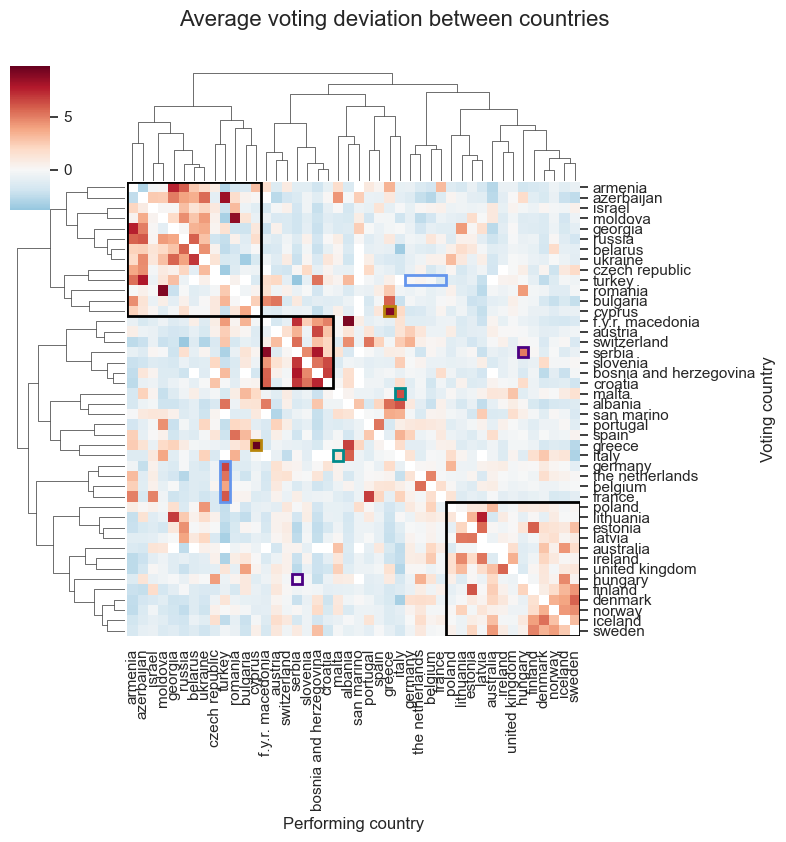

In [96]:
df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

# replace NaN with 0
#df_heatmap2 = df_heatmap2.fillna(0)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
# col_dism = 1 - df_heatmap2.corr()
# col_linkage = hc.linkage(sp.distance.squareform(col_dism), method='complete')


plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(8,8), mask=df_heatmap2.isnull(), 
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap

ax.add_patch(Rectangle((0, 0), 13, 13, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((df_heatmap2.shape[1]-13, df_heatmap2.shape[1]-13), 13, 13, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((13, 13), 7, 7, fill=False, edgecolor='black', lw=2))

ax.add_patch(Rectangle((9, 27), 1, 4, fill=False, edgecolor='cornflowerblue', lw=2)) # turkey
ax.add_patch(Rectangle((27, 9), 4, 1, fill=False, edgecolor='cornflowerblue', lw=2))

ax.add_patch(Rectangle((20, 26), 1, 1, fill=False, edgecolor='darkcyan', lw=2)) # malta
ax.add_patch(Rectangle((26, 20), 1, 1, fill=False, edgecolor='darkcyan', lw=2))

ax.add_patch(Rectangle((16, 38), 1, 1, fill=False, edgecolor='indigo', lw=2)) # serbia-hungary
ax.add_patch(Rectangle((38, 16), 1, 1, fill=False, edgecolor='indigo', lw=2))

ax.add_patch(Rectangle((25, 12), 1, 1, fill=False, edgecolor='darkgoldenrod', lw=2)) # cyprus-greece
ax.add_patch(Rectangle((12, 25), 1, 1, fill=False, edgecolor='darkgoldenrod', lw=2))

plot.fig.suptitle('Average voting deviation between countries', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')

Looks like Germany, the Netherlands, belgium and France vote strongly for Turkey. But Turkey doesn't vote strongly in the other direction. So we have: 

Germany, the Netherlands, Belgium and France -> Turkey (blue box)

Similar for:
- lithuania -> georgia
- serbia -> hungary (purple)
- malta -> italy (green)

On the other hand, cyprus and greece vote for one another (gold box)


In [95]:
print("Average votes for Germany: ", \
    df.loc[(df['To country'] == 'DE')]['Votes'].mean() )

print("Average votes for Germany from Turkey: ", \
df.loc[(df['From country'] == 'TR') & (df['To country'] == 'DE')]['Votes'].mean())


print("Average votes for Turkey: ", \
    df.loc[(df['To country'] == 'TR')]['Votes'].mean() )

print("Average votes for Turkey from Germany: ", \
df.loc[(df['From country'] == 'DE') & (df['To country'] == 'TR')]['Votes'].mean())

Average votes for Germany:  1.624856156501726
Average votes for Germany from Turkey:  2.466666666666667
Average votes for Turkey:  3.1759656652360513
Average votes for Turkey from Germany:  9.642857142857142


## Average Votes per Country

In [28]:
# subset to only the columns we need
df_voting= df[['From country', 'Votes', 'To country', 'Year']].copy()

# Get the average votes to each country, for every from country
df_voting['avg_votes'] = df_voting.groupby(['To country', 'From country'])['Votes'].transform('mean')

df_voting.tail()

,From country,Votes,To country,Year,avg_votes
42723,IT,NaN,SK,2022,NaN
42724,IT,NaN,SM,2022,0.000000
42725,IT,NaN,TR,2022,0.000000
42726,IT,8.0,UA,2022,6.444444
42727,IT,NaN,YU,2022,NaN


In [32]:
df_voting_heatmap = df_voting[['From country', 'avg_votes', 'To country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['From country'] == df_voting_heatmap['To country'], 'avg_votes'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_votes'])

df_voting_heatmap['Voting country'] = df_voting_heatmap['From country'].map({v: k for k, v in country_codes_dict.items()})
df_voting_heatmap['Performing country'] = df_voting_heatmap['To country'].map({v: k for k, v in country_codes_dict.items()})

df_voting_heatmap.head()

,From country,avg_votes,To country,Voting country,Performing country
1,BE,2.000000,AL,belgium,albania
2,BE,4.909091,AM,belgium,armenia
3,BE,3.363636,AT,belgium,austria
4,BE,4.166667,AU,belgium,australia
5,BE,1.769231,AZ,belgium,azerbaijan


In [33]:
df_heatmap = df_voting_heatmap.pivot(index='Voting country', columns='Performing country', values='avg_votes')

df_heatmap.head()

Performing country,albania,armenia,australia,austria,azerbaijan,belarus,belgium,bosnia and herzegovina,bulgaria,croatia,...,slovakia,slovenia,spain,sweden,switzerland,the netherlands,turkey,ukraine,united kingdom,yugoslavia
Voting country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,0.909091,2.500000,0.714286,2.307692,0.333333,0.250000,5.333333,5.40,1.142857,...,NaN,0.000000,3.388889,2.705882,3.142857,1.666667,8.875,1.937500,1.888889,6.5
andorra,0.000000,0.000000,NaN,0.000000,3.500000,0.000000,1.000000,0.000000,0.00,0.000000,...,NaN,0.000000,10.000000,2.833333,0.500000,0.000000,0.500,5.500000,1.000000,1.0
armenia,0.000000,NaN,0.666667,1.500000,0.090909,3.833333,1.333333,1.000000,3.00,0.400000,...,NaN,0.000000,1.571429,3.230769,2.600000,2.000000,0.800,6.000000,0.642857,NaN
australia,0.000000,0.000000,NaN,0.250000,0.000000,0.000000,4.800000,NaN,4.25,0.000000,...,NaN,0.000000,2.428571,6.571429,4.333333,2.000000,NaN,5.400000,3.000000,NaN
austria,3.142857,2.714286,4.000000,NaN,2.000000,0.600000,1.727273,8.750000,4.20,5.000000,...,NaN,0.666667,0.333333,4.055556,3.875000,3.750000,5.625,2.538462,1.333333,12.0


Text(901.1249999999999, 0.5, 'Voting country')

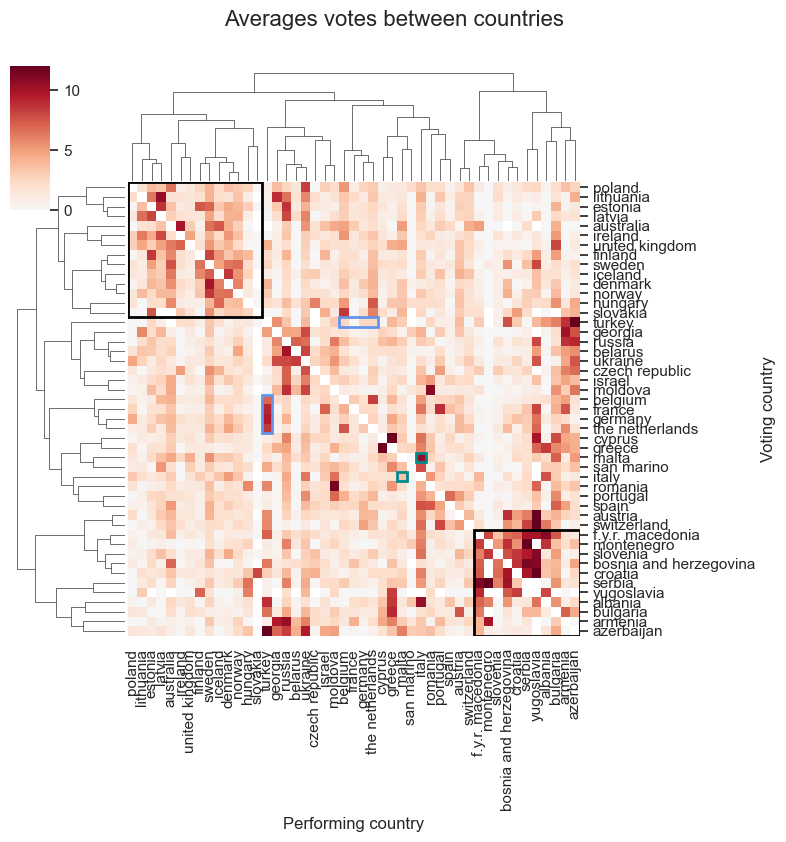

In [67]:
df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

# replace NaN with 0
#df_heatmap2 = df_heatmap2.fillna(0)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
# col_dism = 1 - df_heatmap2.corr()
# col_linkage = hc.linkage(sp.distance.squareform(col_dism), method='complete')


plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(8,8), mask=df_heatmap2.isnull(), 
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap

ax.add_patch(Rectangle((0, 0), 14, 14, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((df_heatmap2.shape[1]-11, df_heatmap2.shape[1]-11), 11, 11, fill=False, edgecolor='black', lw=2))


# asymmetric countries to highlight
ax.add_patch(Rectangle((14, 22), 1, 4, fill=False, edgecolor='cornflowerblue', lw=2)) # turkey
ax.add_patch(Rectangle((22, 14), 4, 1, fill=False, edgecolor='cornflowerblue', lw=2))

ax.add_patch(Rectangle((30, 28), 1, 1, fill=False, edgecolor='darkcyan', lw=2)) # malta
ax.add_patch(Rectangle((28, 30), 1, 1, fill=False, edgecolor='darkcyan', lw=2))

#ax.add_patch(Rectangle((21, 31), 1, 1, fill=False, edgecolor='rebeccapurple', lw=2)) # malta
#ax.add_patch(Rectangle((31, 21), 1, 1, fill=False, edgecolor='rebeccapurple', lw=2))

plot.fig.suptitle('Averages votes between countries', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')

In [37]:
print("Average votes for maldova: ", \
    df.loc[(df['To country'] == 'MD')]['Votes'].mean() )

print("Average votes for maldova from romania: ", \
df.loc[(df['From country'] == 'RO') & (df['To country'] == 'MD')]['Votes'].mean())


print("Average votes for romania: ", \
    df.loc[(df['To country'] == 'RO')]['Votes'].mean() )

print("Average votes for romania from maldova: ", \
df.loc[(df['From country'] == 'MD') & (df['To country'] == 'RO')]['Votes'].mean())

Average votes for maldova:  2.3975409836065573
Average votes for maldova from romania:  11.5
Average votes for romania:  2.056060606060606
Average votes for romania from maldova:  10.923076923076923
